# Generating OSM roads network for florida

In [2]:
from pyrosm import OSM
from pyrosm import get_path
import time

import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt

import re
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
pd.set_option('display.max_columns', None)

/anaconda3/lib/python3.7/site-packages/pyrosm/user_defined.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=osm_keys,


Total time taken to convert .pbf to geopandas: 310.2584671974182 s


<AxesSubplot:>

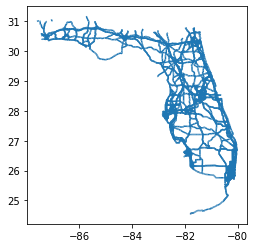

In [3]:
path = "../../mfreight/Road/data/florida-latest.osm.pbf"
# Initialize the OSM parser object
osm = OSM(path)

custom_filter = {"highway": ['motorway','trunk','primary']}

start = time.time()
florida_roads = osm.get_data_by_custom_criteria(custom_filter=custom_filter)
print(f'Total time taken to convert .pbf to geopandas: {time.time()-start} s')
florida_roads.plot()

The geodataframe cannot be transleted to a Graph as it does not contain the incident edges. These latter will be obtaiened through the geometry informations of each link:

In [4]:
def add_incident_nodes(df_in): 
    df = df_in.copy()
    for i in df.itertuples():
        idx = int(i.Index)
        df.loc[idx,'u'] = str(i.geometry.coords[:][0])
        df.loc[idx,'v'] = str(i.geometry.coords[:][-1])
    df.loc[:,'key'] = 0 
    
    df.drop('geometry',inplace = True, axis=1)
    
    return df
    
florida_roads_formatted = add_incident_nodes(florida_roads)


The graph could now be constructed. We are still missing the information about the distance of each edge. <br>
The OSMnx package, contains a function to compute theses edge length using the great circle distance between each nodes. In order to use this function, we need to construct an OSMnx formatted graph. To do so we need two geodataframe:
* all the edges
* all the nodes. 

## Generate an OSMnx formated graph 

The OSMnx package also requires the nodes id to be int.

In [5]:
def gen_nodes_gdfs(df):
    nodes_df = gpd.GeoDataFrame(index = pd.unique(df[['u', 'v']].values.ravel('K')),columns=['y','x','osmid','geometry'],crs="EPSG:4326")
    
    pattern = re.compile(r'(\d+.\d+)')
    
    for row in nodes_df.itertuples():
        x,y = re.findall(pattern,row.Index)
        nodes_df.loc[row.Index,'y'] = float(y)
        nodes_df.loc[row.Index,'x'] = -float(x)
        nodes_df.loc[row.Index,'geometry'] = Point(-float(x),float(y))
        nodes_df.loc[row.Index,'osmid'] = row.Index
        
    nodes_df.loc[:,'idx'] = range(len(nodes_df))
    nodes_df.set_index('idx', drop=True, inplace=True)
    
    return nodes_df

In [6]:
nodes_gdfs = gen_nodes_gdfs(florida_roads_formatted)
nodes_gdfs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 47303 entries, 0 to 47302
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         47303 non-null  object  
 1   x         47303 non-null  object  
 2   osmid     47303 non-null  object  
 3   geometry  47303 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 1.8+ MB


#### Rename nodes index because osmnx only supports int64 indexes

In [7]:
nodes_map = pd.Series(data=nodes_gdfs.index, index=nodes_gdfs['osmid'])

In [8]:
G = ox.graph_from_gdfs(nodes_gdfs, florida_roads_formatted)

nx.relabel_nodes(G, dict(nodes_map), copy=False)
nx.set_node_attributes(G, nodes_gdfs.to_dict('index'), name=None)

Add edge length

In [9]:
ox.utils_graph.add_edge_lengths(G)

In [10]:
G.edges[0, 1453,0]

{'bicycle': 'no',
 'foot': 'no',
 'highway': 'motorway',
 'lanes': '3',
 'maxspeed': '55 mph',
 'oneway': 'yes',
 'ref': 'I 4',
 'sidewalk': 'none',
 'surface': 'asphalt',
 'id': 4342791,
 'timestamp': 1588694096,
 'version': 27,
 'tags': '{"NHS":"Interstate","hgv":"designated","toll":"no","horse":"no","fdot:sis":"yes","fdot:fihs":"401","fdot:county":"Orange, FL","unsigned_ref":"SR 400","source:maxspeed":"FDOT \\"Maximum Speed Limits\\" GIS data, updated August 27, 2011: http://www.dot.state.fl.us/planning/statistics/gis/roaddata.shtm","fdot:rci_section":"280"}',
 'osm_type': 'way',
 'length': 1834.887}

In [11]:
def add_edge_time_df(df):
    
    df['maxspeed'] = df['maxspeed'].fillna('40 mph').astype(str)
    df['maxspeed'] = df['maxspeed'].str.extractall('(\d+)').astype(int).mean(axis=0,level=0)
    df['duration'] = df['length'] / (df['maxspeed'] * 1609.344)
    
def add_edge_time_graph(G):
    nodes, edges = ox.graph_to_gdfs(G, nodes=True)
    add_edge_time_df(edges)
    G = ox.graph_from_gdfs(nodes, edges)
    
    return G

In [12]:
G2 = add_edge_time_graph(G)
G.edges[0, 1453,0]

{'bicycle': 'no',
 'foot': 'no',
 'highway': 'motorway',
 'lanes': '3',
 'maxspeed': '55 mph',
 'oneway': 'yes',
 'ref': 'I 4',
 'sidewalk': 'none',
 'surface': 'asphalt',
 'id': 4342791,
 'timestamp': 1588694096,
 'version': 27,
 'tags': '{"NHS":"Interstate","hgv":"designated","toll":"no","horse":"no","fdot:sis":"yes","fdot:fihs":"401","fdot:county":"Orange, FL","unsigned_ref":"SR 400","source:maxspeed":"FDOT \\"Maximum Speed Limits\\" GIS data, updated August 27, 2011: http://www.dot.state.fl.us/planning/statistics/gis/roaddata.shtm","fdot:rci_section":"280"}',
 'osm_type': 'way',
 'length': 1834.887}

In [13]:
nx.write_gpickle(G,'../../mfreight/Road/data/OSM_florida_G_non_simplified.plk')

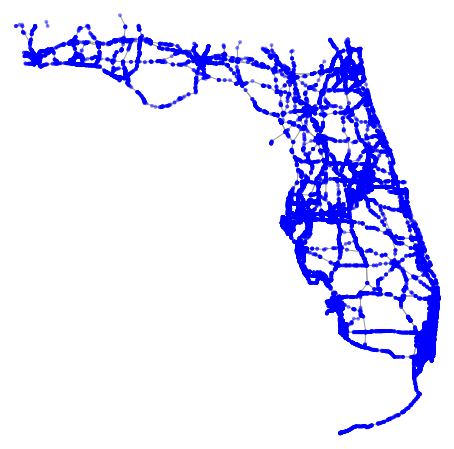

In [14]:
fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white',node_alpha=0.5)

Text(0.5, 1.0, 'connected components size')

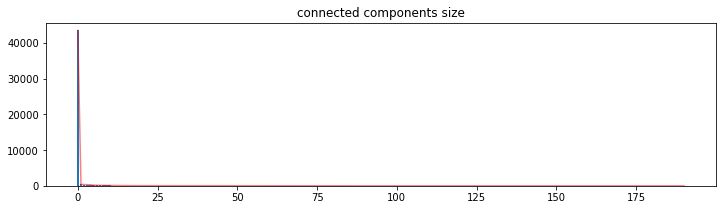

In [15]:
G_undirected = G.to_undirected()
component_size = sorted([len(component) for component in nx.connected_components(G_undirected)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

### Keep only the largest connected component

In [16]:
largest_cc_nodes = max(nx.connected_components(G_undirected), key=len)
largest_cc = G_undirected.subgraph(largest_cc_nodes).copy()

Text(0.5, 1.0, 'connected components size')

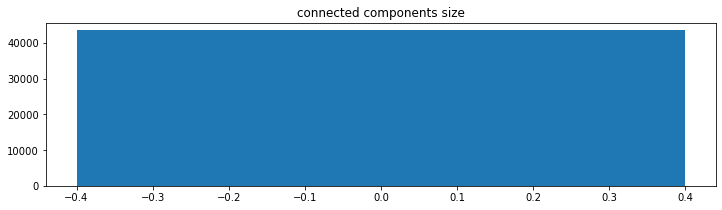

In [17]:
component_size = sorted([len(component) for component in nx.connected_components(largest_cc)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

In [18]:
edges = ox.graph_to_gdfs(largest_cc, nodes=False)

In [19]:
G = add_edge_time_graph(largest_cc)

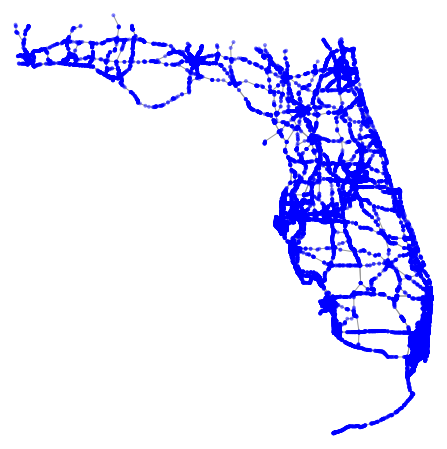

In [20]:
fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white',node_alpha=0.5)

In [21]:
nx.write_gpickle(G,'../../mfreight/Road/data/OSM_florida_G_non_simplified.plk')